![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Contextual Bandits from Real and Synthetic Data: Online Learning and Offline Policy Evaluation*

### **Reinforcement Learning - Final Project**

#### Authors: **Timothy Cassel, Marvin Ernst, Oliver Tausendschön**

Date: July 2, 2025

Instructors: *Hamish Flynn and Vincent Adam*

---

### **07 Additional - OBP-based OPE with Real-World Data**
 
We now revise our earlier work by **relying on OBP's APIs** for proper offline policy evaluation.
 
This allows us to:
- Follow more to what the OBP paper does
- Use robust, validated implementations of LinUCB, LinTS, and evaluation strategies like DR
- Compare multiple policies against logged data without online simulation

---

Import relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from obp.dataset import OpenBanditDataset
from obp.policy import LinUCB, LinTS, Random
from obp.ope import OffPolicyEvaluation, DirectMethod, InverseProbabilityWeighting, DoublyRobust, RegressionModel
from obp.dataset import SyntheticBanditDataset

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

/Users/Admin/Documents/Git/BSE/RL/contextual-bandit-benchmark/obp-py39-env/lib/python3.9/site-packages/torch/torch_version.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]
/Users/Admin/Documents/Git/BSE/RL/contextual-bandit-benchmark/obp-py39-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load Real-World Logged Bandit Feedback

In [2]:
bandit_feedback = dict(
    n_actions=3,
    context=np.load("processed_top3/context_reduced.npy"),
    action=np.load("processed_top3/actions.npy"),
    reward=np.load("processed_top3/rewards.npy"),
    pscore=np.load("processed_top3/pscores.npy"),
)
bandit_feedback["position"] = np.zeros_like(bandit_feedback["action"])
print("Context shape:", bandit_feedback["context"].shape)

Context shape: (53988, 12)


### 2. Fit Reward Model (Random Forest)

In [3]:
X = bandit_feedback["context"]
a = bandit_feedback["action"]
r = bandit_feedback["reward"]

onehot = OneHotEncoder(sparse=False)
a_1hot = onehot.fit_transform(a.reshape(-1, 1))
X_train = np.hstack([X, a_1hot])

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, r)

RandomForestRegressor(random_state=42)

### 3. Define Evaluation Policies

In [4]:
context_dim = bandit_feedback["context"].shape[1]

linucb00 = LinUCB(n_actions=3, dim=context_dim, epsilon=0.0)
linucb01 = LinUCB(n_actions=3, dim=context_dim, epsilon=0.1)
linucb05 = LinUCB(n_actions=3, dim=context_dim, epsilon=0.5)
lints = LinTS(n_actions=3, dim=context_dim) 
random_policy = Random(n_actions=3)

### 4. Offline Policy Evaluation (DM / IPS / DR)

We now use OBP’s built-in estimators to evaluate each policy. Specifically, we evaluate:
- **Direct Method (DM)**: Uses the reward model to predict rewards.
- **Inverse Probability Weighting (IPS)**: Weights observed rewards by propensity scores.
- **Doubly Robust (DR)**: Combines both DM and IPS for improved robustness.

In [ ]:
dm = DirectMethod()
dr = DoublyRobust()
ips = InverseProbabilityWeighting()

: 

Helper function to convert selected actions into a one-hot probability distribution:

In [ ]:
def to_action_dist(chosen_actions: np.ndarray, n_actions: int) -> np.ndarray:
    n_rounds = chosen_actions.shape[0]
    action_dist = np.zeros((n_rounds, n_actions, 1))
    action_dist[np.arange(n_rounds), chosen_actions, 0] = 1.0
    return action_dist

We define a dictionary for storing the results:

In [ ]:
estimated_rewards = {}

The policies - here with names (in dict.):

In [ ]:
policies = {
    "LinUCB (\u03B5=0.0)": linucb00,
    "LinUCB (\u03B5=0.1)": linucb01,
    "LinUCB (\u03B5=0.5)": linucb05,
    "LinTS": lints,
    "Random": random_policy,
}

Defining number of rounds and actions:

In [ ]:
n_rounds = X.shape[0]
n_actions = 3

We initialize a 3D NumPy array filled with zeros, where the third dimension (size 1) is required by OBP’s internal API:

In [ ]:
estimated_rewards_by_reg_model = np.zeros((n_rounds, n_actions, 1))

We compute the estimated expected reward for each possible action at each round using the trained reward model:

In [ ]:
for a_ in range(n_actions):
    a_onehot = onehot.transform(np.full((n_rounds, 1), a_))
    X_input = np.hstack([X, a_onehot])
    estimated_rewards_by_reg_model[:, a_, 0] = model.predict(X_input)

We loop over each policy and apply each estimator to compute the estimated policy value:

In [ ]:
for policy_name, policy in policies.items():
    chosen_actions = np.array([
        policy.select_action(context=x.reshape(1, -1))
        for x in bandit_feedback["context"]
    ])
    action_dist = to_action_dist(chosen_actions, n_actions=n_actions)

    for estimator in [dm, dr, ips]:
        key = f"{policy_name} ({estimator.estimator_name})"
        est = estimator.estimate_policy_value(
            bandit_feedback=bandit_feedback,
            action_dist=action_dist,
            reward=bandit_feedback["reward"],
            action=bandit_feedback["action"],
            pscore=bandit_feedback["pscore"],
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
            if estimator.estimator_name in ["dm", "dr"] else None
        )
        estimated_rewards[key] = est

### 5. Results Table

In [ ]:
result_df = pd.DataFrame(
    {k: [v] for k, v in estimated_rewards.items()}
).T
result_df.columns = ["Estimated Policy Value"]
display(result_df.sort_values("Estimated Policy Value", ascending=False))

### 6. Cumulative Comparison Plot (DR only)

In [ ]:
plt.figure(figsize=(12, 6))
for policy_name, policy in policies.items():
    policy.fit(**bandit_feedback)
    action_dist = policy.predict(context=bandit_feedback["context"])
    dr = DoublyRobust(model_predictor=model)
    est, std = estimate_confidence_interval(
        estimator=dr,
        bandit_feedback=bandit_feedback,
        action_dist=action_dist,
        alpha=0.05,
        n_bootstrap_samples=1000,
        random_state=123,
    )
    y = np.cumsum(np.full(len(bandit_feedback["context"]), est / len(bandit_feedback["context"])))
    plt.plot(y, label=f"{policy_name} (DR)")

plt.title("DR Evaluation of Policies (Cumulative Estimate)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

# Appendix

Here we do some additional calculations using our functions that we have used before (this is not part of the main analysis and was just to check how this looks in a real world mode). Note these functions still only update when the logged action matches the selcted one -as wesate. in the report though, this method is not sound - and has some issues. Not an ideal or clean evaluation. We keep it though just for seeing how they perfrom - though this is not interpretable.

### A. Load Logged Data (Real-World Mode)

In [2]:
X_context = np.load("processed_top3/context_reduced.npy")
actions = np.load("processed_top3/actions.npy")
rewards = np.load("processed_top3/rewards.npy")
pscores = np.load("processed_top3/pscores.npy")

n_rounds, context_dim = X_context.shape
n_arms = len(np.unique(actions))
print(f"Context shape: {X_context.shape}, #Arms: {n_arms}")

Context shape: (53988, 12), #Arms: 3


### B. Fit Reward Estimator $\hat{r}(x, a)$

In [3]:
onehot = OneHotEncoder(sparse_output=False)
a_logged_1hot = onehot.fit_transform(actions.reshape(-1, 1))
X_train = np.hstack([X_context, a_logged_1hot])

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, rewards)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### C. Simulate Policies (Precomputed)

We are not testing for policy robustness, but rather for **how a fixed policy would perform under different offline evaluation methods**. For this reason, we precompute the actions chosen by each policy (e.g., LinUCB, Thompson Sampling) on the dataset and reuse these fixed action sequences across evaluation strategies.

This allows us to:
- Ensure **reproducibility**: the same actions are evaluated under DM, IPS, and DR.
- Enable **fair comparison**: all methods evaluate the same policy behavior.
- Avoid stochastic noise: especially important for random or TS-based policies.

Even though we act *as if the policy were run online*, we simulate its behavior offline by applying it to logged data and using regression models (trained on the logged data) to estimate the rewards.

This approach fits the **real-world mode of offline policy evaluation**, where the true reward function is unknown and must be estimated from observed data.

**Greedy LinUCB (alpha=0):**

In [4]:
results_ucb0 = linucb_all(X_context, actions, rewards,
                         A=[np.identity(context_dim) for _ in range(n_arms)],
                         b=[np.zeros(context_dim) for _ in range(n_arms)],
                         alpha=0.0)

**Thompson Sampling (alpha=0.5):**

In [5]:
results_ts = ts_linear_all(X_context, actions, rewards, alpha=0.5)

**Random Policy:**

In [6]:
rng = np.random.default_rng(123)
a_random = rng.integers(0, n_arms, size=n_rounds)

### D. Evaluate Each Policy

In [28]:
def evaluate_policy(a_eval, model, X_context, onehot, a_logged, rewards, pscores):
    a_eval_1hot = onehot.transform(a_eval.reshape(-1, 1))
    X_eval = np.hstack([X_context, a_eval_1hot])
    
    r_hat = model.predict(X_eval)

    # DM
    dm = r_hat

    # IPS
    matches = a_eval == a_logged
    ips = np.zeros_like(rewards)
    ips[matches] = rewards[matches] / pscores[matches]

    # DR
    correction = np.zeros_like(rewards)
    correction[matches] = (rewards[matches] - r_hat[matches]) / pscores[matches]
    dr = r_hat + correction

    return dm, ips, dr

In [8]:
a_logged = np.array(actions)
r_logged = np.array(rewards)
p_logged = np.array(pscores)

**Evaluate each policy:**

In [9]:
a_ucb = np.array(results_ucb0["chosen_actions"])
a_ts = np.array(results_ts["chosen_actions"])

dm_ucb, ips_ucb, dr_ucb = evaluate_policy(a_ucb, model, X_context, onehot, a_logged, r_logged, p_logged)
dm_ts, ips_ts, dr_ts = evaluate_policy(a_ts, model, X_context, onehot, a_logged, r_logged, p_logged)
dm_rand, ips_rand, dr_rand = evaluate_policy(a_random, model, X_context, onehot, a_logged, r_logged, p_logged)

### E. Compare Evaluation Methods

In [10]:
def plot_eval(dm, ips, dr, label):
    plt.plot(np.cumsum(dm), label=f"{label} (DM)", linestyle="--")
    plt.plot(np.cumsum(ips), label=f"{label} (IPS)", linestyle=":")
    plt.plot(np.cumsum(dr), label=f"{label} (DR)", linestyle="-")

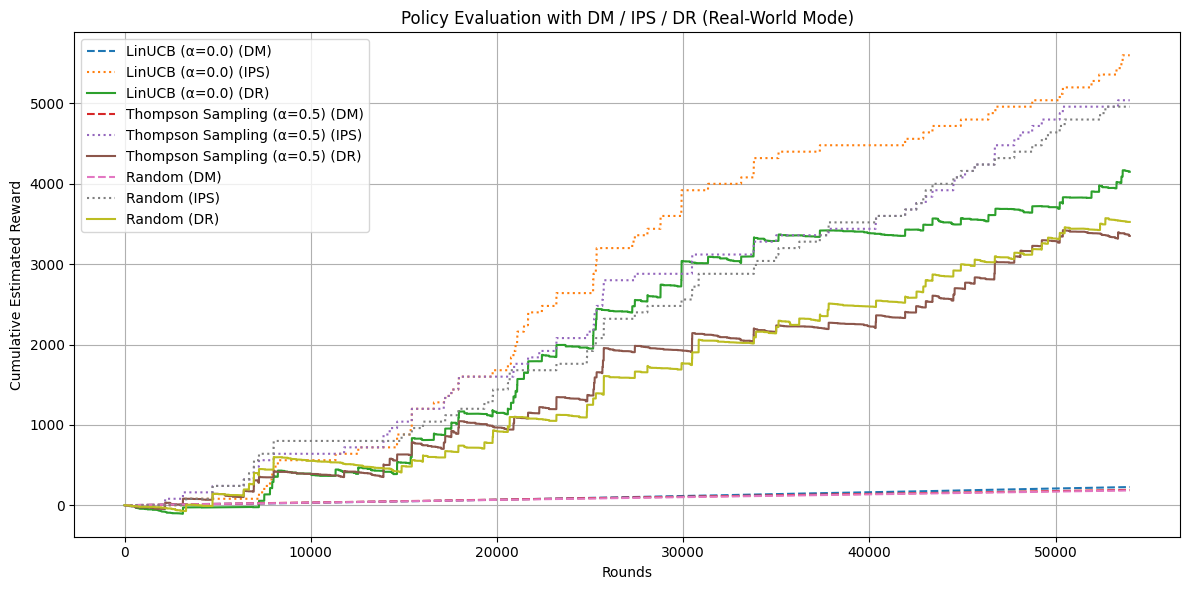

In [ ]:
plt.figure(figsize=(12, 6))
plot_eval(dm_ucb, ips_ucb, dr_ucb, "LinUCB (\u03b1=0.0)")
plot_eval(dm_ts, ips_ts, dr_ts, "Thompson Sampling (\u03b1=0.5)")
plot_eval(dm_rand, ips_rand, dr_rand, "Random")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.title("Policy Evaluation with DM / IPS / DR (Real-World Mode)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F. Policy Comparison Across Different Alpha Values

Now, we evaluate how different exploration parameters affect policy performance under the **Doubly Robust (DR)** estimator.

We run:
- LinUCB with $\alpha \in \{0.0, 0.25, 0.5, 1.0\}$
- Thompson Sampling with $\alpha \in \{0.25, 0.5, 1.0\}$

Each policy outputs a fixed action for each round based on the context. These are evaluated using the reward model trained earlier.

In [29]:
linucb_alphas = [0.0, 0.25, 0.5, 1.0]
ts_alphas = [0.25, 0.5, 1.0]

all_curves = {}

for alpha in linucb_alphas:
    res = linucb_all(X_context, actions, rewards,
                     A=[np.identity(context_dim) for _ in range(n_arms)],
                     b=[np.zeros(context_dim) for _ in range(n_arms)],
                     alpha=alpha)
    a_eval = np.array(res["chosen_actions"])
    dm, ips, dr = evaluate_policy(a_eval, model, X_context, onehot, a_logged, r_logged, p_logged)
    all_curves[f"LinUCB (\u03b1={alpha})"] = np.cumsum(dr)

for alpha in ts_alphas:
    res = ts_linear_all(X_context, actions, rewards, alpha=alpha)
    a_eval = np.array(res["chosen_actions"])
    dm, ips, dr = evaluate_policy(a_eval, model, X_context, onehot, a_logged, r_logged, p_logged)
    all_curves[f"Thompson Sampling (\u03b1={alpha})"] = np.cumsum(dr)

##### **DR Comparison Across Policies**

We now compare **DR estimates** for various values of $\alpha$ for both LinUCB and Thompson Sampling.

This gives insight into how exploration affects estimated performance, given a fixed offline dataset and reward estimator.

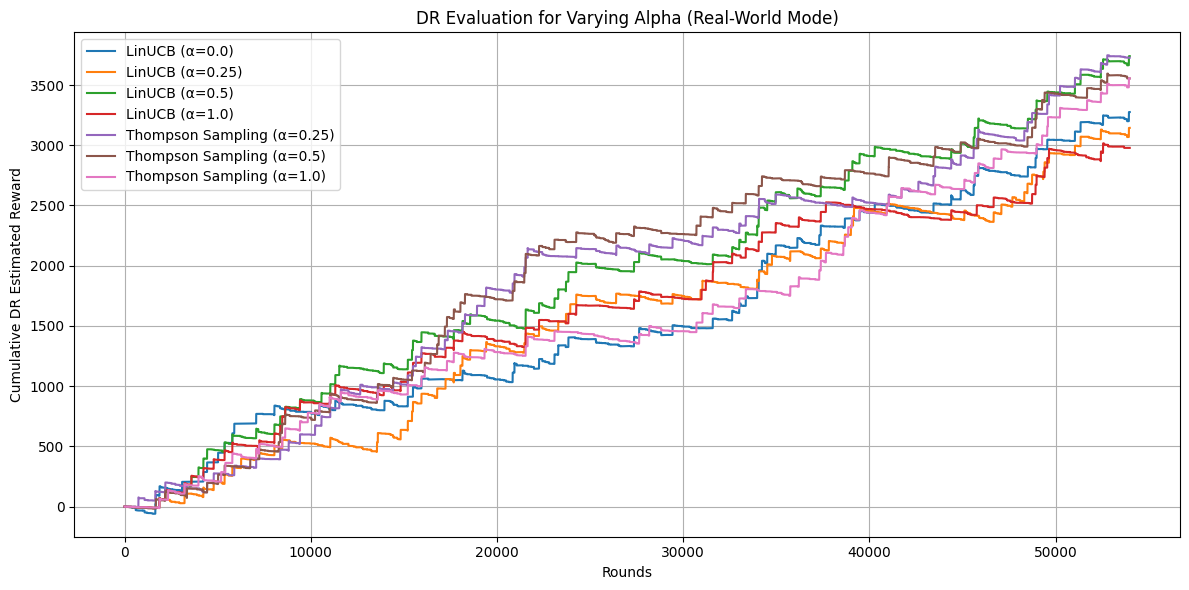

In [30]:
plt.figure(figsize=(12, 6))
for label, curve in all_curves.items():
    plt.plot(curve, label=label)
plt.xlabel("Rounds")
plt.ylabel("Cumulative DR Estimated Reward")
plt.title("DR Evaluation for Varying Alpha (Real-World Mode)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### G. Robustness: Averaging Over Policy Randomness - TS

In earlier evaluations, we fixed the actions chosen by each policy (first, Thompson Sampling) per seed and evaluated them using the same reward estimator.

However, **stochastic policies like Thompson Sampling (TS)** may produce highly variable outcomes across different random draws - even on the same dataset. To test the **robustness and stability** of such policies, we now perform the following:

- For each seed, we keep the data fixed (shuffled once).
- We **rerun TS multiple times (100)** on the same data.
- We compute the **Doubly Robust (DR)** cumulative reward curve for each run.
- We then **average across these 100 runs** to obtain a more reliable estimate of TS's expected behavior under randomness.

This experiment allows us to isolate **policy-induced variance** and compare it to the variance caused by data shuffling.

Setup:

In [14]:
n_rounds = len(X_context)
seed = 0  # Fix data shuffle
n_policy_runs = 100
alpha = 0.5

Fix data:

In [15]:
rng = np.random.default_rng(seed)
idx = rng.permutation(n_rounds)
X = X_context[idx]
a_logged = actions[idx]
r_logged = rewards[idx]
ps = pscores[idx]

Fit reward model:

In [16]:
enc = OneHotEncoder(sparse_output=False)
a_1hot = enc.fit_transform(a_logged.reshape(-1, 1))
X_train = np.hstack([X, a_1hot])
reward_model = RandomForestRegressor(n_estimators=100, random_state=seed)
reward_model.fit(X_train, r_logged)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluate TS multiple times:

In [17]:
dr_runs = []

for run_id in range(n_policy_runs):
    ts_result = ts_linear_all(X, a_logged, r_logged, alpha=alpha)
    a_chosen = np.array(ts_result["chosen_actions"])
    a_chosen_1hot = enc.transform(a_chosen.reshape(-1, 1))
    X_eval = np.hstack([X, a_chosen_1hot])
    r_hat = reward_model.predict(X_eval)

    matches = a_chosen == a_logged
    correction = np.zeros_like(r_logged)
    correction[matches] = (r_logged[matches] - r_hat[matches]) / ps[matches]
    dr = r_hat + correction
    dr_runs.append(np.cumsum(dr))

Average across 100 TS runs:

In [18]:
dr_runs = np.array(dr_runs)
avg_ts_curve = dr_runs.mean(axis=0)
std_ts_curve = dr_runs.std(axis=0)

Results with confidence band:

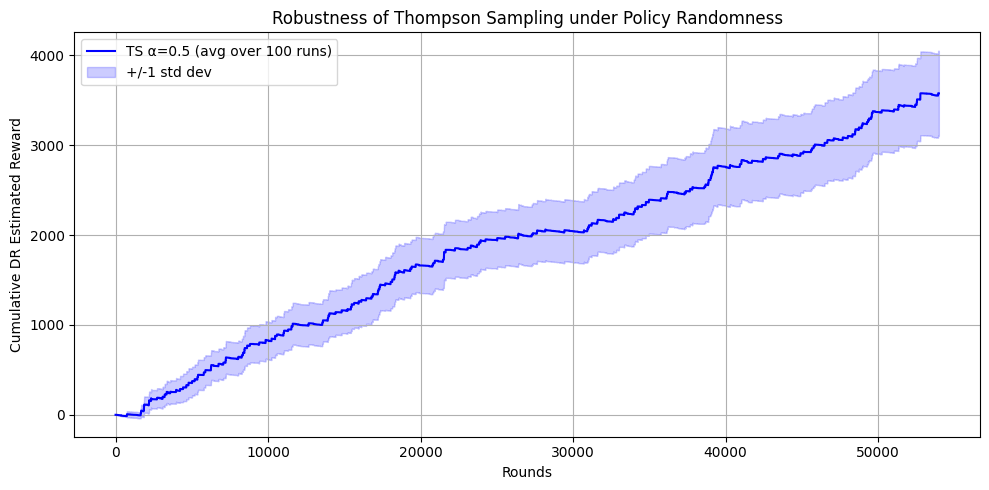

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(avg_ts_curve, label=f"TS \u03b1={alpha} (avg over 100 runs)", color="blue")
plt.fill_between(np.arange(n_rounds),
                 avg_ts_curve - std_ts_curve,
                 avg_ts_curve + std_ts_curve,
                 color="blue", alpha=0.2, label="+/-1 std dev")

plt.title("Robustness of Thompson Sampling under Policy Randomness")
plt.xlabel("Rounds")
plt.ylabel("Cumulative DR Estimated Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### H. Robustness Check: LinUCB ($\alpha = 0.0$ and $\alpha = 0.1$)

While Thompson Sampling is inherently stochastic, **LinUCB is deterministic** for a given data order. Still, we can run LinUCB multiple times on a fixed data permutation to confirm that its behavior is stable under repeated execution.

This serves as a **sanity check** and provides a baseline for comparison:

- For each $\alpha$ setting (0.0 and 0.1), we rerun LinUCB 100 times.
- Since LinUCB is deterministic, all runs should yield the **same cumulative reward curve**.
- If any variation appears, it must come from non-deterministic elements like the reward model (e.g., Random Forest).

**If we see variance, then somehing is going wrong!**

Setup:

In [20]:
linucb_alphas_to_test = [0.0, 0.1]
n_linucb_runs = 100

We use same shuffled data as before and have already fitted the reward model.

Thus, we now store curves per alpha:

In [21]:
linucb_robust_curves = {}

for alpha in linucb_alphas_to_test:
    curves = []
    for run in range(n_linucb_runs):
        A = [np.identity(X.shape[1]) for _ in range(n_arms)]
        b = [np.zeros(X.shape[1]) for _ in range(n_arms)]

        result = linucb_all(X, a_logged, r_logged, A, b, alpha)
        a_chosen = np.array(result["chosen_actions"])
        a_chosen_1hot = enc.transform(a_chosen.reshape(-1, 1))
        X_eval = np.hstack([X, a_chosen_1hot])
        r_hat = reward_model.predict(X_eval)

        matches = a_chosen == a_logged
        correction = np.zeros_like(r_logged)
        correction[matches] = (r_logged[matches] - r_hat[matches]) / ps[matches]
        dr = r_hat + correction

        curves.append(np.cumsum(dr))

    curves = np.array(curves)
    linucb_robust_curves[alpha] = {
        "mean": curves.mean(axis=0),
        "std": curves.std(axis=0),
    }

**Comparison**

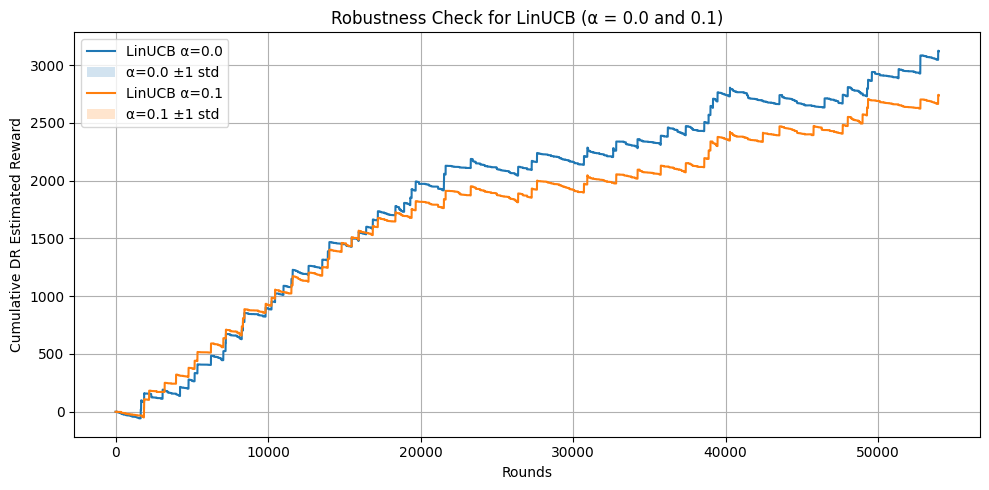

In [22]:
plt.figure(figsize=(10, 5))

for alpha in linucb_alphas_to_test:
    curve = linucb_robust_curves[alpha]["mean"]
    std = linucb_robust_curves[alpha]["std"]
    plt.plot(curve, label=f"LinUCB \u03b1={alpha}")
    plt.fill_between(np.arange(n_rounds),
                     curve - std, curve + std,
                     alpha=0.2, label=f"\u03b1={alpha} ±1 std")

plt.title("Robustness Check for LinUCB (\u03b1 = 0.0 and 0.1)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative DR Estimated Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We do not have any randomness in the algorithm as we can see.